In [127]:
import numpy as np
import pandas
import tensorflow as tf
import csv
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt

no display found. Using non-interactive Agg backend


In [109]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]

POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

BATCH_SIZE = 128

no_epochs = 1000
lr = 0.01

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

In [110]:

def read_data_chars():
  
  x_train, y_train, x_test, y_test = [], [], [], []

  with open('train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_train.append(row[1])
      y_train.append(int(row[0]))

  with open('test_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_test.append(row[1])
      y_test.append(int(row[0]))
  
  x_train = pandas.Series(x_train)
  y_train = pandas.Series(y_train)
  x_test = pandas.Series(x_test)
  y_test = pandas.Series(y_test)
  
  
  char_processor = tf.contrib.learn.preprocessing.ByteProcessor(MAX_DOCUMENT_LENGTH)
  x_train = np.array(list(char_processor.fit_transform(x_train)))
  x_test = np.array(list(char_processor.transform(x_test)))
  y_train = y_train.values
  y_test = y_test.values
  
  return x_train, y_train, x_test, y_test

 

In [111]:

def char_cnn_model(x):
  
  input_layer = tf.reshape(
      tf.one_hot(x, 256), [-1, MAX_DOCUMENT_LENGTH, 256, 1])

    
  with tf.variable_scope('CNN_Layer1'):
    
    conv1 = tf.layers.conv2d(
        input_layer,
        filters=N_FILTERS,
        kernel_size=FILTER_SHAPE1,
        padding='VALID',
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(
        conv1,
        pool_size=POOLING_WINDOW,
        strides=POOLING_STRIDE,
        padding='SAME')

    conv2 = tf.layers.conv2d(
        pool1,
        filters=N_FILTERS,
        kernel_size=FILTER_SHAPE2,
        padding='VALID',
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(
        conv2,
        pool_size=POOLING_WINDOW,
        strides=POOLING_STRIDE,
        padding='SAME')

    pool2 = tf.squeeze(tf.reduce_max(pool2, 1), squeeze_dims=[1]) 

  logits = tf.layers.dense(pool2, MAX_LABEL, activation=None)

  return input_layer, logits



In [115]:
tf.reset_default_graph()

x_train, y_train, x_test, y_test = read_data_chars()

print(len(x_train))
print(len(x_test))

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

inputs, logits = char_cnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(y_, MAX_LABEL), 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # training
    loss = []
    test_acc = []

    for e in range(no_epochs):

        rand_index = np.random.choice(x_train.shape[0], size=BATCH_SIZE)
        x_batch = x_train[rand_index]
        y_batch = y_train[rand_index]

        if(e==0):
            print(x_train.shape)

        _, loss_  = sess.run([train_op, entropy], {x: x_batch, y_: y_batch})
        loss.append(loss_)


        test_acc.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))


        if e%1 == 0:
            print('iter: %d, entropy: %g, accuracy: %g'%(e, loss[e], test_acc[e]))



5600
700
(5600, 100)
iter: 0, entropy: 2.71039, accuracy: 0.0714286
iter: 1, entropy: 2.70307, accuracy: 0.0814286
iter: 2, entropy: 2.71126, accuracy: 0.0728571
iter: 3, entropy: 2.69058, accuracy: 0.0757143
iter: 4, entropy: 2.70311, accuracy: 0.0928571
iter: 5, entropy: 2.70025, accuracy: 0.0928571
iter: 6, entropy: 2.6813, accuracy: 0.0985714
iter: 7, entropy: 2.6623, accuracy: 0.111429
iter: 8, entropy: 2.63395, accuracy: 0.124286
iter: 9, entropy: 2.67877, accuracy: 0.134286
iter: 10, entropy: 2.59656, accuracy: 0.138571
iter: 11, entropy: 2.66612, accuracy: 0.138571
iter: 12, entropy: 2.61757, accuracy: 0.127143
iter: 13, entropy: 2.54433, accuracy: 0.131429
iter: 14, entropy: 2.51158, accuracy: 0.134286
iter: 15, entropy: 2.57502, accuracy: 0.14
iter: 16, entropy: 2.60842, accuracy: 0.131429
iter: 17, entropy: 2.49767, accuracy: 0.134286
iter: 18, entropy: 2.6305, accuracy: 0.137143
iter: 19, entropy: 2.5009, accuracy: 0.142857
iter: 20, entropy: 2.50805, accuracy: 0.145714
ite

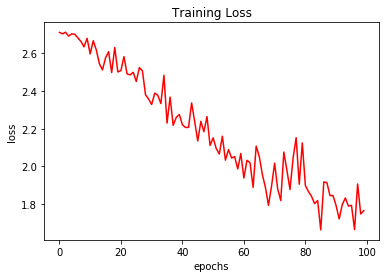

In [133]:
plt.figure(1)
plt.plot(range(no_epochs), loss, 'r' ,label="Training Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
#plt.savefig('q1figs/loss.png')
plt.savefig("q1figs/loss.png")

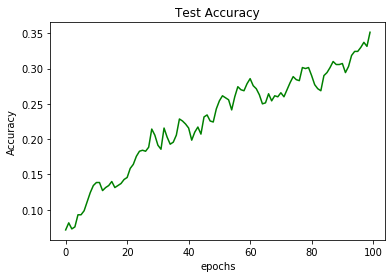

In [134]:
plt.figure(2)
plt.plot(range(no_epochs), test_acc, 'g' ,label="Test Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
#plt.savefig('q1figs/loss.png')
plt.savefig("q1figs/accuracy.png")